# Анализ поведения пользователей в игре Quiz Freeze

В рамках этого исследования нужно проверить следующие гипотезы:

**Гипотеза 1**
По идее, должна быть разница в поведении групп, которые проходят и не проходят обучение. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры?

**Гипотеза 2**
Кажется, повторное прохождение обучения положительно влияет на оплату, верно?

**Гипотеза 3**
Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение?

Сформируем общую цель и задачи для каждой гипотезы:

**Цель:**
Исследовать поведение пользователей в обновлённом приложении.

**Задачи:**
1. Определить, насколько обучение сокращает время прохождения этапов игры.
2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
3. Определить, насколько прозрачен процесс взаимодействия с игрой.


# Выгрузка и преобразование данных

In [1]:
import pandas as pd # Подключаем библиотеки
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

events = pd.read_csv('GD3/7_4_Events.csv', sep=',') # Получаем данные из файлов
purchase = pd.read_csv('GD3/purchase.csv', sep=',')

Так как нам нужны данные только по зарегистрированным пользователям за 2018 год, то полученную информацию необходимо преобразовать:

In [2]:
mask_for_year = ((events.start_time >= '2018-01-01') 
& (events.start_time < '2019-01-01') 
& (events.event_type == 'registration')
) # Создаем фильтр

registered_2018 = events[mask_for_year].user_id.values 
events_2018 = events[events.user_id.isin(registered_2018)] # Применям его к таблице

events_2018.start_time = pd.to_datetime(
    events_2018.start_time, format='%Y-%m-%dT%H:%M:%S') # Преобразоваем столбец к формату даты

events_2018.info() # Проверяем

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66959 entries, 51405 to 118364
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              66959 non-null  int64         
 1   event_type      66959 non-null  object        
 2   selected_level  8342 non-null   object        
 3   start_time      66959 non-null  datetime64[ns]
 4   tutorial_id     32954 non-null  float64       
 5   user_id         66959 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 3.6+ MB


C:\Users\Ursula\AppData\Local\Temp\ipykernel_15044\2190286321.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_2018.start_time = pd.to_datetime(


In [3]:
purchase_2018 = purchase[purchase.user_id.isin(registered_2018)] # Применяем фильтр ко второй таблице

purchase_2018.event_datetime = pd.to_datetime(
    purchase.event_datetime, format='%Y-%m-%dT%H:%M:%S') # Преобразоваем столбец к формату даты

purchase_2018.info() # Проверяем

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 1171 to 2778
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              1600 non-null   int64         
 1   user_id         1600 non-null   int64         
 2   event_datetime  1600 non-null   datetime64[ns]
 3   amount          1600 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 62.5 KB


C:\Users\Ursula\AppData\Local\Temp\ipykernel_15044\2179373382.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_2018.event_datetime = pd.to_datetime(


Для удобства дальнейшей работы с данными объединим обе таблицы, предварительно совершив небольшие преобразования:

In [4]:
purchase_2018['event_type'] = 'purchase' # Добавим в таблицу тип события, для будущего использования
events_2018 = events_2018.rename(columns={"id": "event_id"}) # Переименуем столбцы с одинаковым названием
purchase_2018 = purchase_2018.rename(columns={"id": "purchase_id"}) 

total_events_2018 = pd.concat([events_2018,purchase_2018],sort=False) # Объединим таблицы
total_events_2018 = total_events_2018.reset_index(drop=True).sort_values('start_time') # Обнулим индекс и отсортируем по времени события
total_events_2018.head(10) # Проверим получившиеся данные

C:\Users\Ursula\AppData\Local\Temp\ipykernel_15044\870769212.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_2018['event_type'] = 'purchase' # Добавим в таблицу тип события, для будущего использования


,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,event_datetime,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaT,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaT,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaT,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaT,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaT,NaN
5,80313.0,registration,NaN,2018-01-01 14:08:40,NaN,27837,NaN,NaT,NaN
6,80314.0,registration,NaN,2018-01-01 14:42:58,NaN,27838,NaN,NaT,NaN
7,80315.0,tutorial_start,NaN,2018-01-01 14:54:40,31505.0,27836,NaN,NaT,NaN
8,80316.0,tutorial_start,NaN,2018-01-01 15:00:51,31506.0,27835,NaN,NaT,NaN
9,80317.0,tutorial_finish,NaN,2018-01-01 15:06:15,31506.0,27835,NaN,NaT,NaN


# Первая гипотеза

Для того, чтобы проверить первую гипотезу нужно сравнить время прохождения различных этапов игры для пользователей, которые завершили обучение, для пользователей, которые начали и не закончили обучение и для пользователей, не начинавших обучение.

Первостепенно нужно разделить всех пользоватей на группы.

In [5]:
all_users = total_events_2018["user_id"].unique() # Определяем общее количество пользователей

users_with_started_tutorial = total_events_2018[ # Выделяем группу пользователей, которые начали обучение
    total_events_2018["event_type"] == "tutorial_start"
]["user_id"].unique()

users_with_finished_tutorial = total_events_2018[ # Выделяем группу пользователей, которые закончили обучение
    total_events_2018["event_type"] == "tutorial_finish"
]["user_id"].unique()

users_with_started_and_not_finished_tutorial = total_events_2018[ # Выделяем группу пользователей, которые начали и не закончили обучение
    (~total_events_2018["user_id"].isin(users_with_finished_tutorial)) & (total_events_2018["user_id"].isin(users_with_started_tutorial))
]["user_id"].unique()

users_without_tutorial = total_events_2018[ # Выделяем группу пользователей, которые не начали обучение
    ~total_events_2018["user_id"].isin(users_with_started_tutorial)
]["user_id"].unique()

print("Всего зарегистровано в 2018 году пользователей:", len(all_users))
print("Всего пользователей, начавших обучение:", len(users_with_started_tutorial))
print("Всего пользователей, закончивших обучение:", len(users_with_finished_tutorial))
print("Всего пользователей, начавших, но не закончивших обучение:", len(users_with_started_and_not_finished_tutorial))
print("Всего пользователей, не начавших обучение:", len(users_without_tutorial))

Всего зарегистровано в 2018 году пользователей: 19926
Всего пользователей, начавших обучение: 11858
Всего пользователей, закончивших обучение: 10250
Всего пользователей, начавших, но не закончивших обучение: 1608
Всего пользователей, не начавших обучение: 8068


Посмотрим какие вообще этапы игры существуют:

In [6]:
total_events_2018['event_type'].unique()

array(['registration', 'tutorial_start', 'tutorial_finish',
       'level_choice', 'pack_choice', 'purchase'], dtype=object)

Соотвественно отрезков времени между этапами всего 5:
* Этап 1. От регистрации до начала обучения;
* Этап 2. От начала обучения до его завершенияя;
* Этап 3. От завершения обучения до выбора уровня сложности;
* Этап 4. От выбора уровня сложности до выбора бесплатного пакета вопросов;
* Этап 5. От выбора бесплатного пакета вопросов до оплаты дополнительных вопросов.

Создадим таблицы данных по различным этапам игры:

In [7]:
# Этап регистрации
registration_2018 = total_events_2018[total_events_2018['event_type'] == 'registration'] 
print(registration_2018['user_id'].value_counts().mean()) # Проверяем, что данные не имеют дублей
registration_2018 = registration_2018[["user_id", "start_time"]].rename(
    columns={"start_time": "registration_time"}
) # Форматируем полученную таблицу

# Этап начала первого обучения
tutorial_start_2018 = total_events_2018[total_events_2018['event_type'] == 'tutorial_start'] 
tutorial_start_2018 = tutorial_start_2018.sort_values(
    "start_time"
).drop_duplicates("user_id") # Удаляем дубли
print(tutorial_start_2018['user_id'].value_counts().mean()) # Проверяем, что данные не имеют дублей
tutorial_start_2018 = tutorial_start_2018[["user_id","tutorial_id", "start_time"]].rename(
    columns={"start_time": "tutorial_start_time"}
) # Форматируем полученную таблицу

# Этап окончания первого обучения
tutorial_finish_2018 = total_events_2018[total_events_2018['event_type'] == 'tutorial_finish'] 
# Определяем пользователей начавших первое обучение
first_tutorial_ids = tutorial_start_2018["tutorial_id"].unique()
# Определяем пользователей закончивших первое обучение
tutorial_finish_2018 = tutorial_finish_2018[
    tutorial_finish_2018["tutorial_id"].isin(first_tutorial_ids)
]
print(tutorial_finish_2018['user_id'].value_counts().mean()) # Проверяем, что данные не имеют дублей
tutorial_finish_2018 = tutorial_finish_2018[["user_id", "start_time"]].rename(
    columns={"start_time": "tutorial_finish_time"}
) # Форматируем полученную таблицу

# Этап выбора уровня
level_choice_2018 = total_events_2018[total_events_2018["event_type"] == "level_choice"]
print(level_choice_2018["user_id"].value_counts().mean()) # Проверяем, что данные не имеют дублей
level_choice_2018 = level_choice_2018[["user_id", "start_time"]].rename(
    columns={"start_time": "level_choice_time"}
) # Форматируем полученную таблицу

# Этап выбора бесплатных пакетов вопросов
pack_choice_2018 = total_events_2018[total_events_2018["event_type"] == "pack_choice"]
print(pack_choice_2018["user_id"].value_counts().mean()) # Проверяем, что данные не имеют дублей
pack_choice_2018 = pack_choice_2018[["user_id", "start_time"]].rename(
    columns={"start_time": "pack_choice_time"}
) # Форматируем полученную таблицу

# Этап оплаты дополнительных пакетов
purchase_event_2018 = total_events_2018[total_events_2018["event_type"] == "purchase"]
print(purchase_event_2018["user_id"].value_counts().mean()) # Проверяем, что данные не имеют дублей
purchase_event_2018 = purchase_event_2018[["user_id", "event_datetime"]].rename(
    columns={"event_datetime": "purchase_time"}
) # Форматируем полученную таблицу

1.0
1.0
1.0
1.0
1.0
1.0


Формируем таблицы по каждому этапу для первой группы пользователей, а именно для пользователей, которые начали, но не закончили первое обучение.

In [8]:
started_and_not_finished_registration = registration_2018[ 
    registration_2018["user_id"].isin(users_with_started_and_not_finished_tutorial)
] # Этап регистрации

started_and_not_finished_tutorial_start = tutorial_start_2018[ 
    tutorial_start_2018["user_id"].isin(users_with_started_and_not_finished_tutorial)
] # Этап начала первого обучения

started_and_not_finished_tutorial_finish = tutorial_finish_2018[ 
    tutorial_finish_2018["user_id"].isin(users_with_started_and_not_finished_tutorial)
] # Этап окончания первого обучения

started_and_not_finished_level_choice = level_choice_2018[ 
    level_choice_2018["user_id"].isin(users_with_started_and_not_finished_tutorial)
] # Этап выбора уровня сложности

started_and_not_finished_pack_choice = pack_choice_2018[ 
    pack_choice_2018["user_id"].isin(users_with_started_and_not_finished_tutorial)
] # Этап выбора бесплатного пакета вопросов

started_and_not_finished_purchase = purchase_event_2018[ 
    purchase_event_2018["user_id"].isin(users_with_started_and_not_finished_tutorial)
] # Этап оплаты дополниетельных вопросов

Определим время прохождения этапов для **первой** группы пользователей.

In [9]:
merged_started_and_not_finished_1 = started_and_not_finished_registration.merge(
    started_and_not_finished_tutorial_start, on="user_id", how="inner"
) # Объединяем таблицы для определения промежутка между этапами
merged_started_and_not_finished_1["timedelta"] = (
    merged_started_and_not_finished_1["tutorial_start_time"] - merged_started_and_not_finished_1["registration_time"]
) # Вычисляем разницу во времени
merged_started_and_not_finished_1['hourdelta'] = merged_started_and_not_finished_1['timedelta']/pd.Timedelta('1hour')
merged_started_and_not_finished_1['timedelta'].describe() # Смотрим результат

count                         1608
mean     0 days 05:25:02.892412935
std      0 days 04:33:22.569938660
min                0 days 00:02:34
25%                0 days 01:45:47
50%         0 days 04:23:49.500000
75%                0 days 07:50:33
max                1 days 06:03:23
Name: timedelta, dtype: object

In [10]:
merged_started_and_not_finished_2 = started_and_not_finished_tutorial_start.merge(
    started_and_not_finished_tutorial_finish, on="user_id", how="inner"
) # Объединяем таблицы для определения промежутка между этапами
merged_started_and_not_finished_2["timedelta"] = (
    merged_started_and_not_finished_2["tutorial_finish_time"] - merged_started_and_not_finished_2["tutorial_start_time"]
) # Вычисляем разницу во времени
merged_started_and_not_finished_2['hourdelta'] = merged_started_and_not_finished_2['timedelta']/pd.Timedelta('1hour')
merged_started_and_not_finished_2['timedelta'].describe() # Смотрим результат

count      0
mean     NaT
std      NaT
min      NaT
25%      NaT
50%      NaT
75%      NaT
max      NaT
Name: timedelta, dtype: object

In [11]:
merged_started_and_not_finished_3 = started_and_not_finished_tutorial_start.merge(
    started_and_not_finished_level_choice, on="user_id", how="inner"
) # Объединяем таблицы для определения промежутка между этапами
merged_started_and_not_finished_3["timedelta"] = (
    merged_started_and_not_finished_3["level_choice_time"] - merged_started_and_not_finished_3["tutorial_start_time"]
) # Вычисляем разницу во времени
merged_started_and_not_finished_3['hourdelta'] = merged_started_and_not_finished_3['timedelta']/pd.Timedelta('1hour')
merged_started_and_not_finished_3['timedelta'].describe() # Смотрим результат

count                          743
mean     0 days 02:47:28.088829071
std      0 days 01:42:58.752826263
min                0 days 00:02:05
25%                0 days 01:27:58
50%                0 days 02:42:43
75%         0 days 04:01:45.500000
max                0 days 07:08:18
Name: timedelta, dtype: object

In [12]:
merged_started_and_not_finished_4 = started_and_not_finished_level_choice.merge(
    started_and_not_finished_pack_choice, on="user_id", how="inner"
) # Объединяем таблицы для определения промежутка между этапами
merged_started_and_not_finished_4["timedelta"] = (
    merged_started_and_not_finished_4["pack_choice_time"] - merged_started_and_not_finished_4["level_choice_time"]
) # Вычисляем разницу во времени
merged_started_and_not_finished_4['hourdelta'] = merged_started_and_not_finished_4['timedelta']/pd.Timedelta('1hour')
merged_started_and_not_finished_4['timedelta'].describe() # Смотрим результат

count                          487
mean     0 days 00:05:05.295687885
std      0 days 00:02:35.198952502
min                0 days 00:00:24
25%                0 days 00:03:04
50%                0 days 00:04:48
75%                0 days 00:06:37
max                0 days 00:15:39
Name: timedelta, dtype: object

In [13]:
merged_started_and_not_finished_5 = started_and_not_finished_pack_choice.merge(
    started_and_not_finished_purchase, on="user_id", how="inner"
) # Объединяем таблицы для определения промежутка между этапами
merged_started_and_not_finished_5["timedelta"] = (
    merged_started_and_not_finished_5["purchase_time"] - merged_started_and_not_finished_5["pack_choice_time"]
) # Вычисляем разницу во времени
merged_started_and_not_finished_5['hourdelta'] = merged_started_and_not_finished_5['timedelta']/pd.Timedelta('1hour')
merged_started_and_not_finished_5['timedelta'].describe() # Смотрим результат

count                          131
mean     3 days 21:14:46.908396946
std      2 days 05:36:49.125505005
min                0 days 05:29:38
25%         1 days 22:35:28.500000
50%                3 days 19:11:35
75%                5 days 13:41:45
max                8 days 15:27:43
Name: timedelta, dtype: object

Формируем таблицы по каждому этапу для второй группы пользователей, а именно для пользователей, которые закончили первое обучение.

In [14]:
finished_registration = registration_2018[ 
    registration_2018["user_id"].isin(users_with_finished_tutorial)
] # Этап регистрации

finished_tutorial_start = tutorial_start_2018[ 
    tutorial_start_2018["user_id"].isin(users_with_finished_tutorial)
] # Этап начала первого обучения

finished_tutorial_finish = tutorial_finish_2018[ 
    tutorial_finish_2018["user_id"].isin(users_with_finished_tutorial)
] # Этап окончания первого обучения

finished_level_choice = level_choice_2018[ 
    level_choice_2018["user_id"].isin(users_with_finished_tutorial)
] # Этап выбора уровня сложности

finished_pack_choice = pack_choice_2018[ 
    pack_choice_2018["user_id"].isin(users_with_finished_tutorial)
] # Этап выбора бесплатного пакета вопросов

finished_purchase = purchase_event_2018[ 
    purchase_event_2018["user_id"].isin(users_with_finished_tutorial)
] # Этап оплаты дополниетельных вопросов

Определим время прохождения этапов для **второй** группы пользователей.

In [15]:
merged_finished_1 = finished_registration.merge(
    finished_tutorial_start, on="user_id", how="inner"
) # Объединяем таблицы для определения промежутка между этапами
merged_finished_1["timedelta"] = (
    merged_finished_1["tutorial_start_time"] - merged_finished_1["registration_time"]
) # Вычисляем разницу во времени
merged_finished_1['hourdelta'] = merged_finished_1['timedelta']/pd.Timedelta('1hour')
merged_finished_1['timedelta'].describe() # Смотрим результат

count                        10250
mean     0 days 04:31:04.938146341
std      0 days 04:11:24.828137380
min                0 days 00:00:34
25%         0 days 01:17:55.500000
50%                0 days 03:13:48
75%         0 days 06:37:27.750000
max                1 days 16:03:46
Name: timedelta, dtype: object

In [16]:
merged_finished_2 = finished_tutorial_start.merge(
    finished_tutorial_finish, on="user_id", how="inner"
) # Объединяем таблицы для определения промежутка между этапами
merged_finished_2["timedelta"] = (
    merged_finished_2["tutorial_finish_time"] - merged_finished_2["tutorial_start_time"]
) # Вычисляем разницу во времени
merged_finished_2['hourdelta'] = merged_finished_2['timedelta']/pd.Timedelta('1hour')
merged_finished_2['timedelta'].describe() # Смотрим результат

count                         9830
mean     0 days 00:03:53.174160732
std      0 days 00:01:44.803217992
min                0 days 00:00:16
25%                0 days 00:02:28
50%                0 days 00:03:42
75%                0 days 00:05:08
max                0 days 00:10:06
Name: timedelta, dtype: object

In [17]:
merged_finished_3 = finished_tutorial_finish.merge(
    finished_level_choice, on="user_id", how="inner"
) # Объединяем таблицы для определения промежутка между этапами
merged_finished_3["timedelta"] = (
    merged_finished_3["level_choice_time"] - merged_finished_3["tutorial_finish_time"]
) # Вычисляем разницу во времени
merged_finished_3['hourdelta'] = merged_finished_3['timedelta']/pd.Timedelta('1hour')
merged_finished_3['timedelta'].describe() # Смотрим результат

count                         7197
mean     0 days 02:20:06.017646241
std      0 days 01:24:59.491369321
min                0 days 00:00:58
25%                0 days 01:09:34
50%                0 days 02:14:43
75%                0 days 03:24:49
max                0 days 06:36:45
Name: timedelta, dtype: object

In [18]:
merged_finished_4 = finished_level_choice.merge(
    finished_pack_choice, on="user_id", how="inner"
) # Объединяем таблицы для определения промежутка между этапами
merged_finished_4["timedelta"] = (
    merged_finished_4["pack_choice_time"] - merged_finished_4["level_choice_time"]
) # Вычисляем разницу во времени
merged_finished_4['hourdelta'] = merged_finished_4['timedelta']/pd.Timedelta('1hour')
merged_finished_4['timedelta'].describe() # Смотрим результат

count                         5176
mean     0 days 00:05:18.146058732
std      0 days 00:02:44.449118501
min                0 days 00:00:19
25%                0 days 00:03:05
50%                0 days 00:04:58
75%                0 days 00:07:11
max                0 days 00:15:48
Name: timedelta, dtype: object

In [19]:
merged_finished_5 = finished_pack_choice.merge(
    finished_purchase, on="user_id", how="inner"
) # Объединяем таблицы для определения промежутка между этапами
merged_finished_5["timedelta"] = (
    merged_finished_5["purchase_time"] - merged_finished_5["pack_choice_time"]
) # Вычисляем разницу во времени
merged_finished_5['hourdelta'] = merged_finished_5['timedelta']/pd.Timedelta('1hour')
merged_finished_5['timedelta'].describe() # Смотрим результат

count                         1447
mean     3 days 17:17:59.641326883
std      2 days 04:31:59.804658578
min                0 days 00:44:50
25%         1 days 21:16:05.500000
50%                3 days 12:15:56
75%         5 days 08:53:44.500000
max               10 days 18:33:59
Name: timedelta, dtype: object

Формируем таблицы по каждому этапу для третьей группы пользователей, а именно для пользователей, которые не начачинали обучение

In [20]:
without_tutorial_registration = registration_2018[ 
    registration_2018["user_id"].isin(users_without_tutorial)
] # Этап регистрации

without_tutorial_start = tutorial_start_2018[ 
    tutorial_start_2018["user_id"].isin(users_without_tutorial)
] # Этап начала первого обучения

without_tutorial_finish = tutorial_finish_2018[ 
    tutorial_finish_2018["user_id"].isin(users_without_tutorial)
] # Этап окончания первого обучения

without_tutorial_level_choice = level_choice_2018[ 
    level_choice_2018["user_id"].isin(users_without_tutorial)
] # Этап выбора уровня сложности

without_tutorial_pack_choice = pack_choice_2018[ 
    pack_choice_2018["user_id"].isin(users_without_tutorial)
] # Этап выбора бесплатного пакета вопросов

without_tutorial_purchase = purchase_event_2018[ 
    purchase_event_2018["user_id"].isin(users_without_tutorial)
] # Этап оплаты дополниетельных вопросов

Определим время прохождения этапов для **третьей** группы пользователей.

In [21]:
merged_without_tutorial_1 = without_tutorial_registration.merge(
    without_tutorial_start, on="user_id", how="inner"
) # Объединяем таблицы для определения промежутка между этапами
merged_without_tutorial_1["timedelta"] = (
    merged_without_tutorial_1["tutorial_start_time"] - merged_without_tutorial_1["registration_time"]
) # Вычисляем разницу во времени
merged_without_tutorial_1['hourdelta'] = merged_without_tutorial_1['timedelta']/pd.Timedelta('1hour')
merged_without_tutorial_1['timedelta'].describe() # Смотрим результат

count      0
mean     NaT
std      NaT
min      NaT
25%      NaT
50%      NaT
75%      NaT
max      NaT
Name: timedelta, dtype: object

In [22]:
merged_without_tutorial_2 = without_tutorial_start.merge(
    without_tutorial_finish, on="user_id", how="inner"
) # Объединяем таблицы для определения промежутка между этапами
merged_without_tutorial_2["timedelta"] = (
    merged_without_tutorial_2["tutorial_finish_time"] - merged_without_tutorial_2["tutorial_start_time"]
) # Вычисляем разницу во времени
merged_without_tutorial_2['hourdelta'] = merged_without_tutorial_2['timedelta']/pd.Timedelta('1hour')
merged_without_tutorial_2['timedelta'].describe() # Смотрим результат

count      0
mean     NaT
std      NaT
min      NaT
25%      NaT
50%      NaT
75%      NaT
max      NaT
Name: timedelta, dtype: object

In [23]:
merged_without_tutorial_3 = without_tutorial_registration.merge(
    without_tutorial_level_choice, on="user_id", how="inner"
) # Объединяем таблицы для определения промежутка между этапами
merged_without_tutorial_3["timedelta"] = (
    merged_without_tutorial_3["level_choice_time"] - merged_without_tutorial_3["registration_time"]
) # Вычисляем разницу во времени
merged_without_tutorial_3['hourdelta'] = merged_without_tutorial_3['timedelta']/pd.Timedelta('1hour')
merged_without_tutorial_3['timedelta'].describe() # Смотрим результат

count                           98
mean     0 days 05:15:33.122448979
std      0 days 03:41:00.594664298
min                0 days 00:09:26
25%         0 days 02:15:28.500000
50%         0 days 04:56:05.500000
75%                0 days 08:24:01
max                0 days 18:34:21
Name: timedelta, dtype: object

In [24]:
merged_without_tutorial_4 = without_tutorial_level_choice.merge(
    without_tutorial_pack_choice, on="user_id", how="inner"
) # Объединяем таблицы для определения промежутка между этапами
merged_without_tutorial_4["timedelta"] = (
    merged_without_tutorial_4["pack_choice_time"] - merged_without_tutorial_4["level_choice_time"]
) # Вычисляем разницу во времени
merged_without_tutorial_4['hourdelta'] = merged_without_tutorial_4['timedelta']/pd.Timedelta('1hour')
merged_without_tutorial_4['timedelta'].describe() # Смотрим результат

count                           74
mean     0 days 00:05:23.824324324
std      0 days 00:03:01.230146431
min                0 days 00:00:48
25%         0 days 00:03:09.750000
50%         0 days 00:04:46.500000
75%         0 days 00:07:11.250000
max                0 days 00:13:32
Name: timedelta, dtype: object

In [25]:
merged_without_tutorial_5 = without_tutorial_pack_choice.merge(
    without_tutorial_purchase, on="user_id", how="inner"
) # Объединяем таблицы для определения промежутка между этапами
merged_without_tutorial_5["timedelta"] = (
    merged_without_tutorial_5["purchase_time"] - merged_without_tutorial_5["pack_choice_time"]
) # Вычисляем разницу во времени
merged_without_tutorial_5['hourdelta'] = merged_without_tutorial_5['timedelta']/pd.Timedelta('1hour')
merged_without_tutorial_5['timedelta'].describe() # Смотрим результат

count                           22
mean     4 days 04:49:33.590909090
std      2 days 04:58:40.602573417
min                0 days 09:35:48
25%                2 days 15:49:22
50%                4 days 04:38:42
75%         5 days 23:34:55.750000
max                7 days 11:56:49
Name: timedelta, dtype: object

Создадим объединяющую таблицу с полученными данными по всем группам пользователей:

In [26]:
all_groups = pd.DataFrame(
    data = [
        ['Этап 1', 'Группа 1',
         merged_started_and_not_finished_1['hourdelta'].mean()],
        ['Этап 1', 'Группа 2',
         merged_finished_1['hourdelta'].mean()],
        ['Этап 1', 'Группа 3',
         merged_without_tutorial_1['hourdelta'].mean()],
        ['Этап 2', 'Группа 1',
         merged_started_and_not_finished_2['hourdelta'].mean()],
        ['Этап 2', 'Группа 2',
         merged_finished_2['hourdelta'].mean()],
        ['Этап 2', 'Группа 3',
         merged_without_tutorial_2['hourdelta'].mean()],
        ['Этап 3', 'Группа 1',
         merged_started_and_not_finished_3['hourdelta'].mean()],
        ['Этап 3', 'Группа 2',
         merged_finished_3['hourdelta'].mean()],
        ['Этап 3', 'Группа 3',
         merged_without_tutorial_3['hourdelta'].mean()],
        ['Этап 4', 'Группа 1',
         merged_started_and_not_finished_4['hourdelta'].mean()],
        ['Этап 4', 'Группа 2',
         merged_finished_4['hourdelta'].mean()],
        ['Этап 4', 'Группа 3',
         merged_without_tutorial_4['hourdelta'].mean()],
        ['Этап 5', 'Группа 1',
         merged_started_and_not_finished_5['hourdelta'].mean()],
        ['Этап 5', 'Группа 2',
         merged_finished_5['hourdelta'].mean()],
        ['Этап 5', 'Группа 3',
         merged_without_tutorial_5['hourdelta'].mean()],
        ],
    columns = ['Этап', 'Группа', 'Время']
)
display(all_groups)

,Этап,Группа,Время
0,Этап 1,Группа 1,5.417470
1,Этап 1,Группа 2,4.518038
2,Этап 1,Группа 3,NaN
3,Этап 2,Группа 1,NaN
4,Этап 2,Группа 2,0.064771
5,Этап 2,Группа 3,NaN
6,Этап 3,Группа 1,2.791136
7,Этап 3,Группа 2,2.335005
8,Этап 3,Группа 3,5.259201
9,Этап 4,Группа 1,0.084804


Для наглядности результатов оформим данные в столбчатую диаграмму.

Text(0.5, 1.0, 'Среднее время для каждого этапа игры по группам')

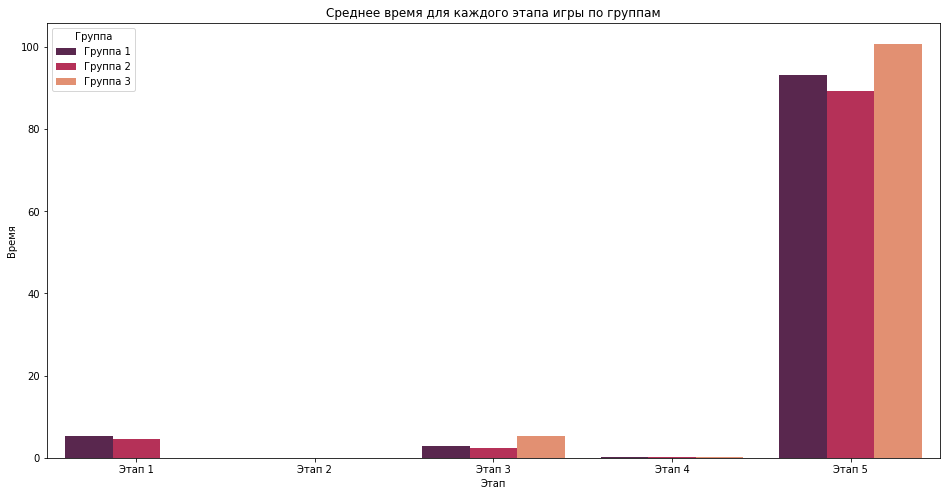

In [27]:
fig = plt.figure(figsize=(16, 8))
barplot = sns.barplot(
    data = all_groups,
    x = all_groups['Этап'],
    y = all_groups['Время'],
    hue = all_groups['Группа'],
    palette="rocket"
)
barplot.set_title('Среднее время для каждого этапа игры по группам')

## Вывод

На диаграмме среднего времени для каждого этапа игры по группам видно, что время прохождения значительно выше у третьей группы (пользователей не начинавших обучение), 100,8 ч. для последнего этапа.

Исходя из этого гипотеза о том, что существует разница в поведении групп, которые проходят и не проходят обучение подтверждена. Если пользователь начал, но не закончил обучение, то время прохождения этапов у него все равно значительного ниже, чем у того, кто даже не наинал обучние. Таким образом можно сделать вывод о том, что пользователи, которые взаимодействовали с обучением имею большую вовлеченность в игру и быстрее переходят к оплате дополнительных вопросов.

# Вторая гипотеза

Для того, чтобы проверить вторую гипотезу нужно определить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь.

Для начала выделим все события окончания обучения, затем сгруппируем их по пользователю, чтобы получить количество обучений, а после сгруппируем полученные данные по количеству обучений, чтобы получить искомое число пользователей по количеству завершенных обучений.

In [28]:
all_tutorial_finished = total_events_2018[
    total_events_2018['event_type'] == 'tutorial_finish'] # Выделяем из общей таблицы

users_tutorial_finished = (
    all_tutorial_finished.groupby(["user_id"])["tutorial_id"].count().reset_index()
) # Группируем по пользователям

group_by_count_tutorial = (
    users_tutorial_finished.groupby(["tutorial_id"])["user_id"].count().reset_index()
) # Группируем по количеству обучений

display(group_by_count_tutorial) # Проверяем результат

,tutorial_id,user_id
0,1,8015
1,2,1321
2,3,345
3,4,178
4,5,117
5,6,101
6,7,97
7,8,54
8,9,22


Теперь нужно определить количество пользователей, оплативших дополнительные вопросы в зависимости от количества пройденых обучений. Для этого выполним следующие действия:

In [29]:
# Создадаим маску с пользователями, которые завершили обучение
mask_users_tutorial_finished = users_tutorial_finished["user_id"].unique() 
users_finished_tutorial_purchase = total_events_2018[
    total_events_2018["user_id"].isin(mask_users_tutorial_finished)
] # Применим маску к общей таблице

tutorial_purchase = users_finished_tutorial_purchase[
    users_finished_tutorial_purchase["event_type"] == "purchase"
] # Выделим только события оплаты

users_purchase_tutorial = (
    tutorial_purchase.groupby(["user_id"])["purchase_id"].count().reset_index()
) # Группируем по пользователям

merge_users_purchase_tutorial = users_tutorial_finished.merge(
   users_purchase_tutorial, on = "user_id", how = "inner"
) # Соединяем таблицу по количеству обучений и количеству оплаты

group_by_count_purchase = (
    merge_users_purchase_tutorial.groupby(["tutorial_id"])["purchase_id"].count().reset_index()
) # Группируем оплату по количеству обучений

display(group_by_count_purchase) # Смотрим результат

,tutorial_id,purchase_id
0,1,1143
1,2,182
2,3,44
3,4,19
4,5,19
5,6,15
6,7,15
7,8,6
8,9,4


Далее объединим таблицы и посчитаем конверсию между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь.

In [30]:
merged_tutorial_purchase = group_by_count_tutorial.merge(
   group_by_count_purchase, on = "tutorial_id", how = "inner"
) # Объединяем таблицы

merged_tutorial_purchase = merged_tutorial_purchase[["tutorial_id","user_id","purchase_id"]].rename(
    columns={"tutorial_id": "Количество обучений", "user_id": "Количество пользователей", "purchase_id": "Количество оплат"}
) # Переименовываем столбцы

merged_tutorial_purchase["Конверсия"] = round(
    merged_tutorial_purchase["Количество оплат"]
    /merged_tutorial_purchase["Количество пользователей"]*100, 2
    ) # Вычисляем конверсию

display(merged_tutorial_purchase) # Смотрим результат

,Количество обучений,Количество пользователей,Количество оплат,Конверсия
0,1,8015,1143,14.26
1,2,1321,182,13.78
2,3,345,44,12.75
3,4,178,19,10.67
4,5,117,19,16.24
5,6,101,15,14.85
6,7,97,15,15.46
7,8,54,6,11.11
8,9,22,4,18.18


Визуализируем таблицу посредством столбчатой диаграммы для наглядности.

Text(0.5, 1.0, 'Зависимость оплаты дополнительных вопросов от количества пройденных обучений')

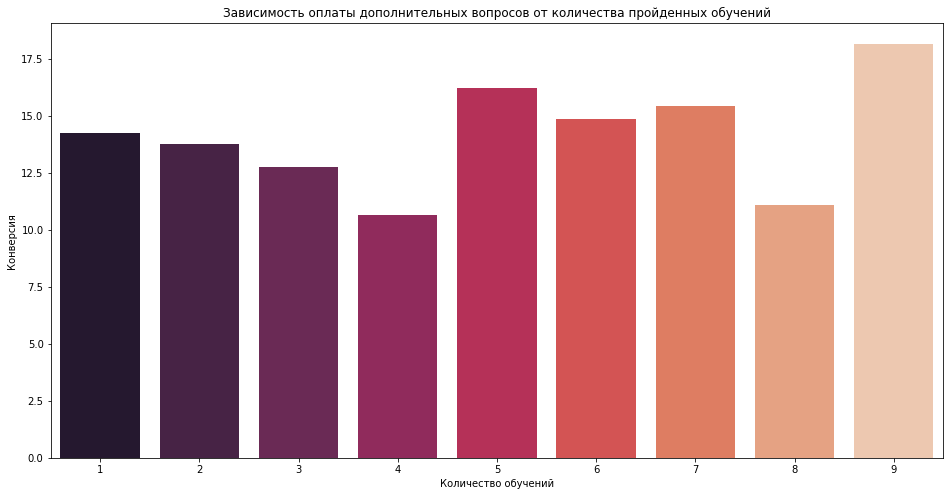

In [31]:
fig = plt.figure(figsize=(16, 8))
barplot = sns.barplot(
    data = merged_tutorial_purchase,
    x = merged_tutorial_purchase['Количество обучений'],
    y = merged_tutorial_purchase['Конверсия'],
    palette="rocket"    
)
barplot.set_title('Зависимость оплаты дополнительных вопросов от количества пройденных обучений')

## Вывод

На диаграмме зависимости оплаты дополнительных вопросов от количества пройденных обучений видно, что чем, больше пользователем пройдено обучений, тем более вероятна покупка дополнительных вопросов. Пользователи, прошедшие обучение 9 раз в 18 % случаев покупали дополнительные вопросы.

Исходя из этого гипотеза о том, что повторное прохождение обучения положительно влияет на оплату подтверждена. Можно сделать вывод о том, что пользователи, которые проходили обучение более 5 раз, чаще переходят к оплате дополнительных вопросов.

# Третья гипотеза

Для того, чтобы проверить третью гипотезу нужно выяснить, как часто пользователи начинают обучение после выбора уровня сложности.

Сначала выделим все события выбора уровня сложности и события начала обучения. События выбора уровня сложности мы уже выделяли, проверяя первую гипотезу, роэтому обратимся к данной таблице.

In [32]:
level_choice_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8342 entries, 19 to 66957
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            8342 non-null   int64         
 1   level_choice_time  8342 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 195.5 KB


События начала обучения мы так же выделяли, но тога мы затрагивали только первое обучение, сейчас же нам понадобятся все данные о начале обучения.

In [33]:
all_tutorial_start = total_events_2018[
    total_events_2018['event_type'] == 'tutorial_start'
] # Выделяем все события начала обучения

all_tutorial_start = all_tutorial_start[["user_id", "start_time"]].rename(
    columns={"start_time": "tutorial_start_time"}
) # Переименовываем столбцы для удобства

Соединим полученные таблицы и вычислим разницу во времени между выбором уровня сложности и началом обучения.

In [34]:
difference_level_choices = all_tutorial_start.merge(
    level_choice_2018, on = "user_id", how = "inner"
) # Соединяем таблицы

difference_level_choices["timedelta"] = (
    difference_level_choices["level_choice_time"] - difference_level_choices["tutorial_start_time"]
) # Вычисляем разницу

# Вычисляем разницу в часах
difference_level_choices['hourdelta'] = difference_level_choices['timedelta']/pd.Timedelta('1hour') 

difference_level_choices['hourdelta'].describe() # Смотрим результат

count    12686.000000
mean         0.911213
std          3.785172
min        -23.857500
25%          0.228472
50%          1.650833
75%          3.131667
max         21.493333
Name: hourdelta, dtype: float64

Как мы видим, некоторые данные принимают отрицательный результат, это значит, что обучение проходилось уже после выбора уровня сложности. Определим количество таких обучений.

In [35]:
# Создадим функцию, которая при отрицательном значении будет присваивать единицу
def function_differnce(x):
    if x > 0:
        return 0
    else: return 1 
    
difference_level_choices["after"] = (
    difference_level_choices['hourdelta'].apply(function_differnce)    
) # Применим данную функцию к столбцу с разницей в часах

count_after_tutorial = (
    difference_level_choices.groupby(["user_id"])["after"].sum().reset_index()
) # Сгруппируем данные по пользователям


Итак мы получили данные по количеству обучений начатых после выбора уровня сложности, осталось только определить процент пользователей начинавших обучение после выбора сложности от общего количества пользователей, выбравших уровень сложности.

In [36]:
percentage_of_tutorial = (count_after_tutorial[count_after_tutorial['after'] != 0]['after'].count()
      / level_choice_2018["user_id"].count()*100)

print("Пользователи начинают обучение после выбора уровня сложности в", round(percentage_of_tutorial, 2), "% случаев.")

Пользователи начинают обучение после выбора уровня сложности в 16.61 % случаев.


## Вывод

Исходя из полученных результатов можно сделать вывод о том, что пользователи, которые проходили выбрали уровень сложности в 17 процентах случаев возвращаются к обучению.

# Общий вывод

Проведя данное исследование мы выяснили, что обучение сильно влияет на показатели игры. Пользователи, которые прошли или хотябы начали обучение имеют большую вовлеченность. Также с количеством пройденных обучений растет и вероятность оплаты дополнительных пакетов вопросов. Стоит отметить, что к обучению возвращаются даже после выбора сложности, что позволяет сделать вывод о том, что 17% пользователей непонятно взаимодействие игрой. Из всего этого следует порекомендовать сделать более интуитвный интерфейс на начальных этапах для вхождения в игру без обучения, либо сделать обучение обязательным этапом.